In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

def dataloader(train_dataset, test_dataset):
    # Set the length of the batch (number of samples per batch)
    batch_size = 50

    train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset,
        batch_size = batch_size,
    )

    test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset,
        batch_size = batch_size,
    )
    print(f'training has：{len(train_loader)} batch of data！')
    print(f'testing has：{len(test_loader)} batch of data！')

    return train_loader, test_loader

def load_data():
    # used to transform image into a tensor
    T = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    # download data and transform to tensor
    train_dataset =  torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
    test_dataset = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

    print("The number of training data：", len(train_dataset))
    print("The number of testing data：", len(test_dataset))

    # show one image from training data
    plt.imshow(train_dataset[0][0][0], cmap='gray')
    plt.show()

    # When we get the all datasets, we design the dataloader for CNN
    return dataloader(train_dataset, test_dataset)

def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

def validate(model, data):
    if torch.cuda.is_available():
      device = torch.device('cuda:0')
    else:
      device = torch.device('cpu')
    model.eval()
    val_accuracy = 0.0
    num_correct = 0
    num_samples = 0

    for val_features, val_labels in data:

        # Evaluate valset performance
        val_features = val_features.to(device)
        val_labels = val_labels.to(device)
        valiprediction = model(val_features)
        values, val_predicted = torch.max(valiprediction, axis=1)
        num_correct += (val_predicted == val_labels).sum().item()
        num_samples += len(val_labels)
        val_accuracy = 100 * num_correct / num_samples

    return val_accuracy

The number of training data： 60000
The number of testing data： 10000


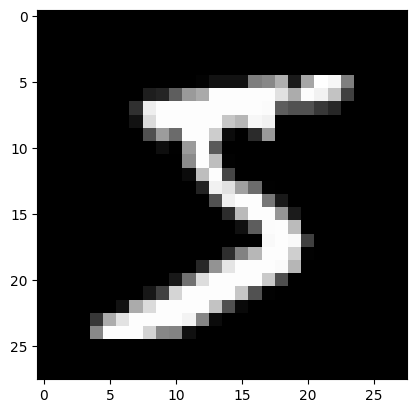

training has：1200 batch of data！
testing has：200 batch of data！
=== Model Configuration ===
Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning Rate: 0.001
Device: cuda:0

Saving Best Model with Accuracy:  95.94 %
Epoch: 1 Accuracy : 95.94 %
Saving Best 

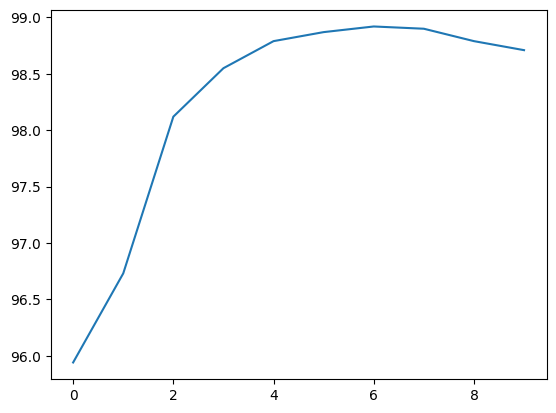

In [10]:
import copy
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    print("Using cpu")

learning_rate = 0.001

epoches = 10

train_loader, test_loader = load_data()


model = create_lenet().to(device)  # Instantiate this class
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Show model configuration
print("=== Model Configuration ===")
print(model)  # Prints the architecture (layers, shapes, etc.)
print("\nLoss Function:", lossFun)
print("Optimizer:", optimizer)
print("Learning Rate:", learning_rate)
print("Device:", device)
print("============================\n")


best_model_path = 'centralized_best_model.pth'

accuracies = []
max_accuracy = 0.0

for epoch in range(epoches):
    model.train()  # The model starts the training step.

    for i, data in enumerate(train_loader):
        # print(i)
        features = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
        preds = model(features)
        loss = lossFun(preds, labels)
        loss.backward()  # Backpropagation
        optimizer.step()


    accuracy = float(validate(model, test_loader))
    accuracies.append(accuracy)


    if accuracy > max_accuracy:
        best_model = copy.deepcopy(model)
        max_accuracy = accuracy
        torch.save(best_model.state_dict(), best_model_path)
        print("Saving Best Model with Accuracy: ", accuracy, "%")
    print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
plt.plot(accuracies)

In [11]:
# loading best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load('centralized_best_model.pth', weights_only=True)
model.load_state_dict(state_dict)

model.eval()
model.to(device)

# testing saved best model
accuracy = float(validate(model, test_loader))
print("Accuracy of the loaded model：", accuracy)

Accuracy of the loaded model： 98.92
